# PIXEL-WISE-SUPERVISION-REPLAY-BiFPN-FOURIER

# COMPUTATION

In [1]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
%cd '/content/drive/MyDrive/BTP/replay-attack-processed'

/content/drive/MyDrive/BTP/replay-attack-processed


In [3]:
import numpy as np
import zipfile, os, cv2, random
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model,Model
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
import glob
import csv
from pathlib import Path
from io import BytesIO
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# DataLoader + Prediction

In [ ]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
# IMG_SHAPE = (256, 256, 3)
archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Train: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/val.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Val: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/test.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Test: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

Train: Total = 91705 , Attack = 69215 , Real = 22490
Val: Total = 90952 , Attack = 68467 , Real = 22485
Test: Total = 121028 , Attack = 91799 , Real = 29229


In [ ]:
# RUN THIS CODE CELL LOCALLY
# IMG_SHAPE = (256, 256, 3)

image_paths = [k for k in glob.iglob('./data/train' + '/**/*.jpg', recursive=True)]
print('Train: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

image_paths = [k for k in glob.iglob('./data/test' + '/**/*.jpg', recursive=True)]
print('Test: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

image_paths = [k for k in glob.iglob('./data/val' + '/**/*.jpg', recursive=True)]
print('Validation: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

Train: Total = 91705 , Attack = 69215 , Real = 22490
Test: Total = 121028 , Attack = 91799 , Real = 29229
Validation: Total = 90952 , Attack = 68467 , Real = 22485


In [4]:
def new_py_function(func, inp, Tout, name=None):
  def wrapped_func(*flat_inp):
    reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,expand_composites=True)
    out = func(*reconstructed_inp)
    return tf.nest.flatten(out, expand_composites=True)
  flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
  flat_out = tf.py_function(
      func=wrapped_func, 
      inp=tf.nest.flatten(inp, expand_composites=True),
      Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
      name=name)
  spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, 
                                   expand_composites=True)
  out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
  return out

def _dtype_to_tensor_spec(v):
  return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
  return v.dtype if isinstance(v, tf.TensorSpec) else v

In [5]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
class DataLoader:
  def __init__(self, dataset_path, batch_size=4, image_size=(256, 256), shuffle=True):
    self.archive = zipfile.ZipFile(dataset_path, 'r')
    self.images_paths = [k for k in list(self.archive.namelist()) if '.jpg' in k]
    random.shuffle(self.images_paths)
    self.length = len(self.images_paths)
    self.dim = image_size
    dataset = tf.data.Dataset.from_tensor_slices(self.images_paths).map(
            self.pad_map_fn, num_parallel_calls=3
          )
    if shuffle:
      dtaset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=3)
    # dataset = dataset.repeat()
    self.dataset = dataset.apply(tf.data.experimental.ignore_errors())  
                  
  def __len__(self):
        return self.length

  def load_tf_image(self, image_path):
    image_path = image_path.numpy().decode("utf-8")
    img_data = self.archive.read(image_path.strip())
    image = np.frombuffer(img_data, np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    original_image = image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.dim)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # label - spoof = 0, real = 1
    if 'attack' in image_path:
      label =  tf.constant([0])
      label_8 = tf.zeros_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.zeros_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.zeros_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.zeros_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
    if 'real' in image_path:
      label = tf.constant([1])
      label_8 = tf.ones_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.ones_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.ones_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.ones_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))

    return {'original_image': original_image, 'image': image, 'label': label, 'label_8': label_8, 'label_4': label_4, 'label_2': label_2, 'label_1': label_1}

  def pad_map_fn(self, img_path):
    return new_py_function(self.load_tf_image, inp=[img_path], Tout=({"original_image":tf.float32, "image": tf.float32, "label": tf.int32, 'label_8': tf.float32, 'label_4': tf.float32, 'label_2': tf.float32, 'label_1': tf.float32}))

In [ ]:
# RUN THIS CODE CELL LOCALLY
loader = DataLoader('./data/train', batch_size=32,shuffle=False)

In [ ]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', batch_size=32,shuffle=False)

In [ ]:
# loader.load_tf_image('./data/train/real/frame_15.jpg')['label_1']

In [ ]:
# loader.pad_map_fn('./data/train/real/frame_15.jpg')

In [ ]:
dataset = loader.dataset.take(2)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['image'].shape, a['label'].shape, a['label_8'].shape, a['label_4'].shape, a['label_2'].shape, a['label_1'].shape)


(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)
(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)


In [6]:
IMG_SHAPE = (256, 256, 3)

In [7]:
class RevisitResNet50(tf.keras.Model):
  def __init__(self, name="revisit_resnet50", **kwargs):
    super(RevisitResNet50, self).__init__()
    self.backbone = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    # avg. pooling
    self.avgpool_8 = layers.AveragePooling2D(pool_size=(1,1), strides=1, padding='valid', data_format=None)
    self.avgpool_4= layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='valid', data_format=None)
    self.avgpool_2= layers.AveragePooling2D(pool_size=(4,4), strides=4, padding='valid', data_format=None)
    self.avgpool_1= layers.AveragePooling2D(pool_size=(8,8), strides=8, padding='valid', data_format=None)
    # 1x1 conv
    self.theta_8 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_4 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_2 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_1 = layers.Conv2D(1, (1,1), activation='sigmoid')
    # dense layer
    self.fc = layers.Dense(1, activation='sigmoid')
    # loss
    self.loss_object = tf.keras.losses.BinaryCrossentropy()

  def call(self, input_img, label_8, label_4, label_2, label_1):
    F = self.backbone(input_img)
    # M1
    x1_1 = self.avgpool_1(F)
    M1_1 = self.theta_1(x1_1)
    # M2
    x2_1 = self.avgpool_2(F)
    M2_1 = layers.Concatenate()([self.theta_2(x2_1) , tf.image.resize(M1_1,[2,2])])
    # M4
    x4_1 = self.avgpool_4(F)
    M4_1 = layers.Concatenate()([self.theta_4(x4_1) , tf.image.resize(M2_1,[4,4])])
    # M8
    x8_1 = self.avgpool_8(F)
    M8_1 = layers.Concatenate()([self.theta_8(x8_1) , tf.image.resize(M4_1,[8,8])])

    # layers.Concatenate([tf.image.resize()])
    # x1_2 = self.avgpool_1(x1_1)
    x1_2 = self.avgpool_1(F)
    M1_2 = layers.Concatenate()([self.theta_1(x1_2),M1_1])

    # x1_3 = self.avgpool_1(x1_2)
    x1_3 = self.avgpool_1(F)
    M1_3 = layers.Concatenate()([self.theta_1(x1_3),M1_2,M1_1])

    # x4_2 = self.avgpool_4(x4_1)
    x4_2 = self.avgpool_4(F)
    M4_2 = layers.Concatenate()([self.theta_4(x4_2), M4_1,tf.image.resize(M8_1,[4,4])])

    # x2_2 = self.avgpool_2(x2_1)
    x2_2 = self.avgpool_2(F)
    M2_2 = layers.Concatenate()([self.theta_2(x2_2),M2_1,tf.image.resize(M4_2,[2,2]),tf.image.resize(M1_3,[2,2])])

    # x4_3 = self.avgpool_4(x4_2)
    x4_3 = self.avgpool_4(F)
    M4_3 = layers.Concatenate()([self.theta_4(x4_3), M4_2, M4_1, tf.image.resize(M2_2,[4,4])])

    # x8_2 = self.avgpool_8(x8_1)
    x8_2 = self.avgpool_8(F)
    M8_2 = layers.Concatenate()([self.theta_8(x8_2),M8_1,tf.image.resize(M4_3,[8,8])])

    # x1_4 = self.avgpool_1(x1_3)
    x1_4 = self.avgpool_1(F)
    M1_4 = layers.Concatenate()([self.theta_1(x1_4),M1_3]) 

    # x4_4 = self.avgpool_4(x4_3)
    x4_4 = self.avgpool_4(F)
    M4_4 = layers.Concatenate()([self.theta_4(x4_4),M4_3])

    # x1_5 = self.avgpool_1(x1_4)
    x1_5 = self.avgpool_1(F)
    M1_5 = layers.Concatenate()([self.theta_1(x1_5),M1_4,M1_3])

    # x2_3 = self.avgpool_2(x2_2)
    x2_3 = self.avgpool_2(F)
    M2_3 = layers.Concatenate()([self.theta_2(x2_3),M2_2,tf.image.resize(M4_4,[2,2]),tf.image.resize(M1_5,[2,2])])

    # x4_5 = self.avgpool_4(x4_4)
    x4_5 = self.avgpool_4(F)
    M4_5 = layers.Concatenate()([self.theta_4(x4_5), M4_4, M4_3, tf.image.resize(M2_3,[4,4])])

    # x8_3 = self.avgpool_8(x8_2)
    x8_3 = self.avgpool_8(F)
    M8_3 = layers.Concatenate()([self.theta_8(x8_3),M8_2,tf.image.resize(M4_5,[8,8])])

    # x1_6 = self.avgpool_1(x1_5)
    x1_6 = self.avgpool_1(F)
    M1_6 = layers.Concatenate()([self.theta_1(x1_6),M1_5])

    # x4_6 = self.avgpool_4(x4_5)
    x4_6 = self.avgpool_4(F)
    M4_6 = layers.Concatenate()([self.theta_4(x4_5),M4_5])

    # x1_7 = self.avgpool_1(x1_6)
    x1_7 = self.avgpool_1(F)
    M1_7 = layers.Concatenate()([self.theta_1(x1_7),M1_6,M1_5])

    # x2_4 = self.avgpool_2(x2_3)
    x2_4 = self.avgpool_2(F)
    M2_4 = layers.Concatenate()([self.theta_2(x2_4),M2_3,tf.image.resize(M4_6,[2,2]),tf.image.resize(M1_7,[2,2])])

    # x4_7 = self.avgpool_4(x4_6)
    x4_7 = self.avgpool_4(F)
    M4_7 = layers.Concatenate()([self.theta_4(x4_7), M4_6, M4_5, tf.image.resize(M2_4,[4,4])])

    # x8_4 = self.avgpool_8(x8_3)
    x8_4 = self.avgpool_8(F)
    M8_4 = layers.Concatenate()([self.theta_8(x8_4),M8_3,tf.image.resize(M4_7,[8,8])])

    M8 = M8_4
    M4 = M4_7
    M2 = M2_4
    M1 = M1_7

    # concatenate and predict
    x = layers.Concatenate(axis=1)([layers.Flatten()(M8), layers.Flatten()(M4), layers.Flatten()(M2), layers.Flatten()(M1)])
    y_pred = self.fc(x)
    # pyramid loss
    pyramid_loss = tf.reduce_mean([self.loss_object(label_8, M8), self.loss_object(label_4, M4), self.loss_object(label_2, M2), self.loss_object(label_1, M1)])
    self.add_loss(pyramid_loss)

    return y_pred
  
  def build_model(self):
    x = layers.Input(shape=IMG_SHAPE)
    label_8 = layers.Input(shape=(8,8,1), dtype="float32")
    label_4 = layers.Input(shape=(4,4,1), dtype="float32")
    label_2 = layers.Input(shape=(2,2,1), dtype="float32")
    label_1 = layers.Input(shape=(1,1,1), dtype="float32")
    return Model(inputs=[x, label_8, label_4, label_2, label_1], outputs=self.call(x, label_8, label_4, label_2, label_1))


revisit_model = RevisitResNet50()
test_model = revisit_model.build_model()
test_model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_2[0][0]']                
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 1, 1, 2048)  0           ['resnet50[0][0]',               
 oling2D)                                                         'resnet50[0][0]',               
                             

In [8]:
def calculate_apcer(y_true, y_pred):
    true_spoof = 0  #### Spoof being 1
    false_real = 0  #### real being 0
    for i in range(len(y_true)):
        target = y_true[i]
        pred = y_pred[i]
        if target:
            true_spoof += 1
            if not pred:
                false_real += 1
    return false_real / true_spoof if true_spoof else 0

In [9]:
def calculate_bpcer(y_true, y_pred):
    true_real = 0  #### Spoof being 1
    false_spoof = 0  #### real being 0
    for i in range(len(y_true)):   
        target = y_true[i]
        pred = y_pred[i]
        if not target:
            true_real += 1
            if pred:
                false_spoof += 1
    return false_spoof / true_real if true_real else 0

In [10]:
def calculate_acer(apcer, bpcer):
  return (apcer + bpcer) / 2

In [11]:
def get_recall(matrix):
  TP = matrix[0][0]
  FN = matrix[1][0]
  print(TP)
  recall = TP / (TP + FN)
  return recall

In [12]:
def get_precesion(matrix):
  TP = matrix[0][0]
  FP = matrix[0][1]
  precesion = TP / (TP + FP)
  return precesion

In [13]:
def get_F1_score(recall,precision):
  F1_score = 2*recall*precision / (recall + precision)
  return F1_score

In [14]:
def get_acccuracy(matrix , total_classes):
  TP = matrix[0][0]
  TN = matrix[1][1]
  return (TP + TN) / total_classes


In [15]:
train_loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', batch_size=64, shuffle=True)
val_loader =  DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/val.zip', batch_size=64, shuffle=False)
test_loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/test.zip', batch_size=64, shuffle=False)

In [16]:
# len(train_loader.dataset)
print(len(train_loader))
print(len(val_loader))

91705
90952


In [17]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=5e-5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=5e-5)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

In [18]:
revisit_model.load_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/cp.ckpt')

In [ ]:
epochs = 25
start = datetime.now() 
for epoch in range(20,epochs+1): 
  print("Start of epoch %d" % (epoch,))

  # Iterate over the batches of the dataset
  for step, batch_train in enumerate(train_loader.dataset):
    # print(batch_train['image'].shape, batch_train['label'].shape, batch_train['label_8'].shape, batch_train['label_4'].shape, batch_train['label_2'].shape, batch_train['label_1'].shape)
    
    with tf.GradientTape() as tape:
        pred = revisit_model(batch_train['image'], batch_train['label_8'], batch_train['label_4'], batch_train['label_2'], batch_train['label_1'], training=True)
        # compute bcse loss
        loss = bce_loss_fn(batch_train['label'], pred)
        loss += sum(revisit_model.losses)  # add pyramid loss

    grads = tape.gradient(loss, revisit_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, revisit_model.trainable_weights))

    loss_metric(loss)

    if (step+1) % 750 == 0:
      diff_time = datetime.now()-start
      days, seconds = diff_time.days, diff_time.seconds
      hours = days * 24 + seconds // 3600
      minutes = (seconds % 3600) // 60
      seconds = seconds %https://github.com/pineapple45/pixel-wise-supervision-anti-face-spoofing/blob/master/Pixel%20Wise%20Supervision%20-%20REPLAY-BiFPN.ipynb 60
      print("step %d: mean loss = %.6f, time = %d:%d:%d" % (step+1, loss_metric.result(), hours, minutes, seconds))
      revisit_model.save_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/cp.ckpt')

revisit_model.save_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/cp.ckpt')

Start of epoch 20
step 750: mean loss = 0.003264, time = 0:17:32
Start of epoch 21
step 750: mean loss = 0.003205, time = 0:49:56
Start of epoch 22
step 750: mean loss = 0.003151, time = 1:22:27
Start of epoch 23
step 750: mean loss = 0.003101, time = 1:54:48
Start of epoch 24
step 750: mean loss = 0.003057, time = 2:27:24
Start of epoch 25
step 750: mean loss = 0.003017, time = 2:59:48


### THE OUTPUT OF ABOVE TRAINING IS AS BELOW (TOTAL ~ 30 epochs)

Start of epoch 0
step 750: mean loss = 0.246263, time = 0:12:44

Start of epoch 1
step 750: mean loss = 0.132357, time = 0:35:26

Start of epoch 2
step 750: mean loss = 0.099830, time = 0:58:21

Start of epoch 3
step 750: mean loss = 0.083328, time = 1:20:32

Start of epoch 4
step 750: mean loss = 0.072835, time = 1:43:3

Start of epoch 5
step 750: mean loss = 0.065554, time = 2:5:48

Start of epoch 6
step 750: mean loss = 0.060130, time = 2:28:6

Start of epoch 7
step 750: mean loss = 0.055899, time = 2:50:24

Start of epoch 8
step 750: mean loss = 0.052477, time = 3:12:42

Start of epoch 9
step 750: mean loss = 0.049640, time = 3:35:5

Start of epoch 10
step 750: mean loss = 0.047250, time = 3:57:21

Start of epoch 11
step 750: mean loss = 0.045190, time = 4:19:37

Start of epoch 12
step 750: mean loss = 0.043380, time = 4:42:8

Start of epoch 13
step 750: mean loss = 0.041795, time = 5:4:31

Start of epoch 14
step 750: mean loss = 0.040386, time = 5:26:55

Start of epoch 15
step 750: mean loss = 0.039120, time = 5:49:35

Start of epoch 16
step 750: mean loss = 0.037986, time = 6:12:7

Start of epoch 17
step 750: mean loss = 0.036962, time = 6:34:25

Start of epoch 18
step 750: mean loss = 0.036018, time = 6:56:50

Start of epoch 19
step 750: mean loss = 0.035150, time = 7:19:20

Start of epoch 20
step 750: mean loss = 0.034356, time = 7:41:40

Start of epoch 21
step 750: mean loss = 0.033614, time = 8:4:9

Start of epoch 22
step 750: mean loss = 0.032926, time = 8:26:10

Start of epoch 23
step 750: mean loss = 0.032288, time = 8:48:7


Start of epoch 24
step 750: mean loss = 0.003264, time = 0:17:32

Start of epoch 25
step 750: mean loss = 0.003205, time = 0:49:56

Start of epoch 26
step 750: mean loss = 0.003151, time = 1:22:27

Start of epoch 27
step 750: mean loss = 0.003101, time = 1:54:48

Start of epoch 27
step 750: mean loss = 0.003057, time = 2:27:24

Start of epoch 29
step 750: mean loss = 0.003017, time = 2:59:48


In [ ]:
temp = ['Start of epoch 0 step 750: mean loss = 0.246263, time = 0:12:44',
'Start of epoch 1 step 750: mean loss = 0.132357, time = 0:35:26',
'Start of epoch 2 step 750: mean loss = 0.099830, time = 0:58:21',
'Start of epoch 3 step 750: mean loss = 0.083328, time = 1:20:32',
'Start of epoch 4 step 750: mean loss = 0.072835, time = 1:43:3',
'Start of epoch 5 step 750: mean loss = 0.065554, time = 2:5:48',
'Start of epoch 6 step 750: mean loss = 0.060130, time = 2:28:6',
'Start of epoch 7 step 750: mean loss = 0.055899, time = 2:50:24',
'Start of epoch 8 step 750: mean loss = 0.052477, time = 3:12:42',
'Start of epoch 9 step 750: mean loss = 0.049640, time = 3:35:5',
'Start of epoch 10 step 750: mean loss = 0.047250, time = 3:57:21',
'Start of epoch 11 step 750: mean loss = 0.045190, time = 4:19:37',
'Start of epoch 12 step 750: mean loss = 0.043380, time = 4:42:8',
'Start of epoch 13 step 750: mean loss = 0.041795, time = 5:4:31',
'Start of epoch 14 step 750: mean loss = 0.040386, time = 5:26:55',
'Start of epoch 15 step 750: mean loss = 0.039120, time = 5:49:35',
'Start of epoch 16 step 750: mean loss = 0.037986, time = 6:12:7',
'Start of epoch 17 step 750: mean loss = 0.036962, time = 6:34:25',
'Start of epoch 18 step 750: mean loss = 0.036018, time = 6:56:50',
'Start of epoch 19 step 750: mean loss = 0.035150, time = 7:19:20',
'Start of epoch 20 step 750: mean loss = 0.034356, time = 7:41:40',
'Start of epoch 21 step 750: mean loss = 0.033614, time = 8:4:9',
'Start of epoch 22 step 750: mean loss = 0.032926, time = 8:26:10',
'Start of epoch 23 step 750: mean loss = 0.032288, time = 8:48:7',
'Start of epoch 24 step 750: mean loss = 0.003264, time = 0:17:32',
'Start of epoch 25 step 750: mean loss = 0.003205, time = 0:49:56',
'Start of epoch 26 step 750: mean loss = 0.003151, time = 1:22:27',
'Start of epoch 27 step 750: mean loss = 0.003101, time = 1:54:48',
'Start of epoch 27 step 750: mean loss = 0.003057, time = 2:27:24',
'Start of epoch 29 step 750: mean loss = 0.003017, time = 2:59:48']

splits = []
for x in temp:
  if 'mean loss' in x:
    val = x.split('mean loss')
    for t in val:
      if ', time = ' in t:
        s = t.split(', time')
        m = s[0].split(' = ')
        splits.append(m[1])

splits
all_loss = [float(s) for s in splits]
all_epochs = [i for i in range(len(all_loss))]
all_loss

[0.246263,
 0.132357,
 0.09983,
 0.083328,
 0.072835,
 0.065554,
 0.06013,
 0.055899,
 0.052477,
 0.04964,
 0.04725,
 0.04519,
 0.04338,
 0.041795,
 0.040386,
 0.03912,
 0.037986,
 0.036962,
 0.036018,
 0.03515,
 0.034356,
 0.033614,
 0.032926,
 0.032288,
 0.003264,
 0.003205,
 0.003151,
 0.003101,
 0.003057,
 0.003017]

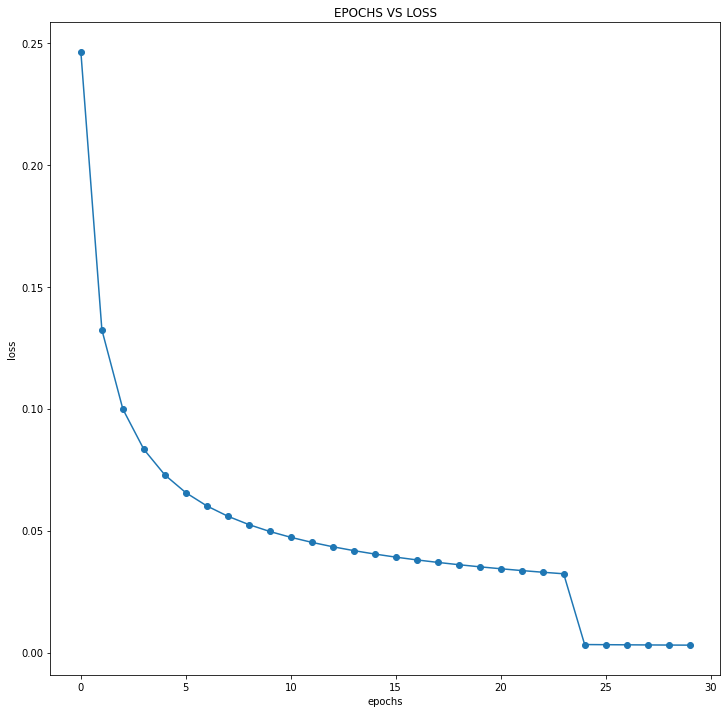

In [ ]:
# GRAPH FOR LOSS VS EPOCH
plt.plot(all_epochs,all_loss,marker='o')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('EPOCHS VS LOSS')
plt.show()

In [ ]:
# store all labels and corrosponding predictions only of validation set
ths = 0.88
all_labels = []
all_predictions = []
for step, batch in enumerate(val_loader.dataset):
  pred = revisit_model(batch['image'], batch['label_8'], batch['label_4'], batch['label_2'], batch['label_1'], training=False)
  for i in pred.numpy().reshape(batch['label'].shape[0]):
    if i>ths:
      pred_ = 1  
      all_predictions.append(pred_)
    else:
      pred_ = 0
      all_predictions.append(pred_)
  for i in batch['label'].numpy().reshape(batch['label'].shape[0]):
    label = int(i) 
    all_labels.append(label)

In [ ]:
print(len(all_labels))
print(len(all_predictions))

89408
89408


In [ ]:
print(tf.math.confusion_matrix(all_labels,all_predictions))
apcer = calculate_apcer(all_labels, all_predictions)
bpcer = calculate_bpcer(all_labels, all_predictions)
acer = calculate_acer(apcer,bpcer)
print(apcer , bpcer, acer)

tf.Tensor(
[[67277    20]
 [  320 21791]], shape=(2, 2), dtype=int32)
0.014472434534846909 0.0002971900679079305 0.00738481230137742


In [ ]:
# store all labels and corrosponding predictions only of val set for all different thresholds
# ths = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# all_thresh_labels_preds_val = []
# for t in ths:
#   print('starting calculations for threshold - ',t)
all_labels_val = []
all_predictions_val_raw = []
for step, batch in enumerate(val_loader.dataset):
  pred = revisit_model(batch['image'], batch['label_8'], batch['label_4'], batch['label_2'], batch['label_1'], training=False)
  for i in pred.numpy().reshape(batch['label'].shape[0]):
    all_predictions_val_raw.append(i)
  for i in batch['label'].numpy().reshape(batch['label'].shape[0]):
    label = int(i) 
    all_labels_val.append(label)
  # all_thresh_labels_preds_val.append({ 'thresh': t , 'labels': all_labels_val, 'preds': all_predictions_val })

# save all_thresh_labels_preds_val array into csv file
csv_path_val = "/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/all_labels_preds_val.csv"
a = np.array(all_labels_val)
b = np.array(all_predictions_val_raw)
df = pd.DataFrame({"labels" : a, "preds_raw" : b})
df.to_csv(csv_path_val, index=False)

In [20]:
def get_thresh_list(start,end,step):
  return np.arange(start,end,step)

In [ ]:
csv_path_val = "/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/all_labels_preds_val.csv"
data_from_csv = pd.read_csv(csv_path_val)
# print(data_from_csv['thresh'])
# print(data_from_csv['labels'])
labels = data_from_csv['labels'].tolist()
preds = data_from_csv['preds_raw'].tolist()

thresh = get_thresh_list(0,1.05,0.05)
all_thresh_labels_preds_val = []
for t in thresh:
  preds_ = []
  for p in preds:
    if p > t:
      pred_ = 1
      preds_.append(pred_)
    else:
      pred_ = 0
      preds_.append(pred_)
      
  all_thresh_labels_preds_val.append({ 'thresh': t, 'preds': preds_, 'labels':labels })

In [ ]:
print(all_thresh_labels_preds_val[15]['labels'])
print(all_thresh_labels_preds_val[15]['preds'])

[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

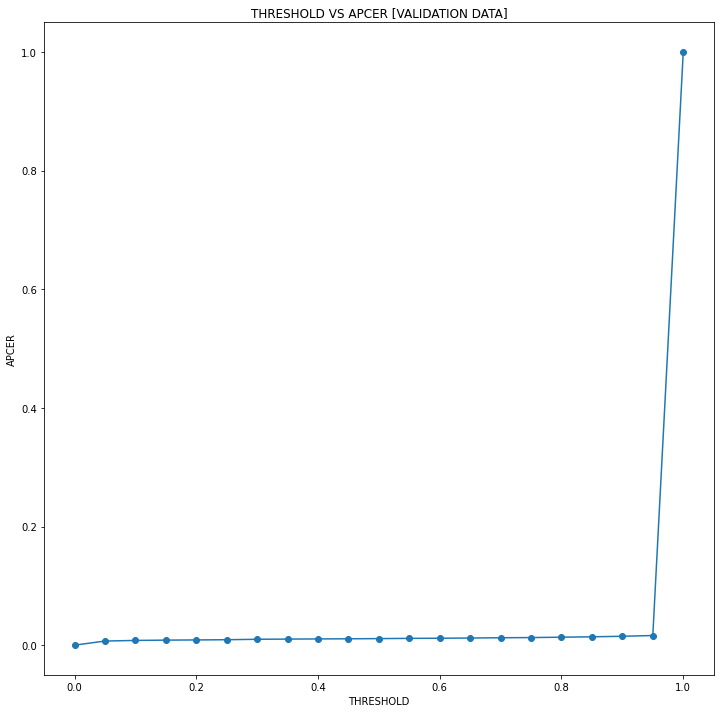

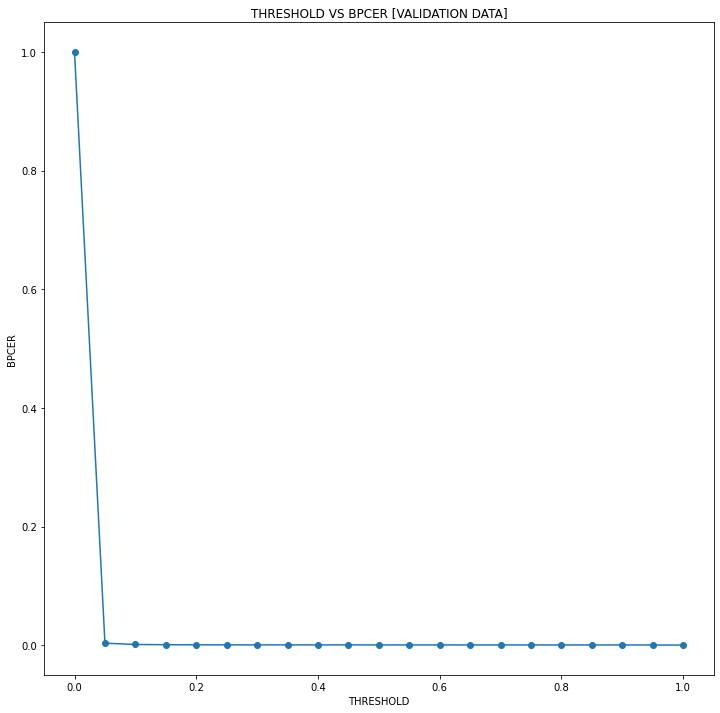

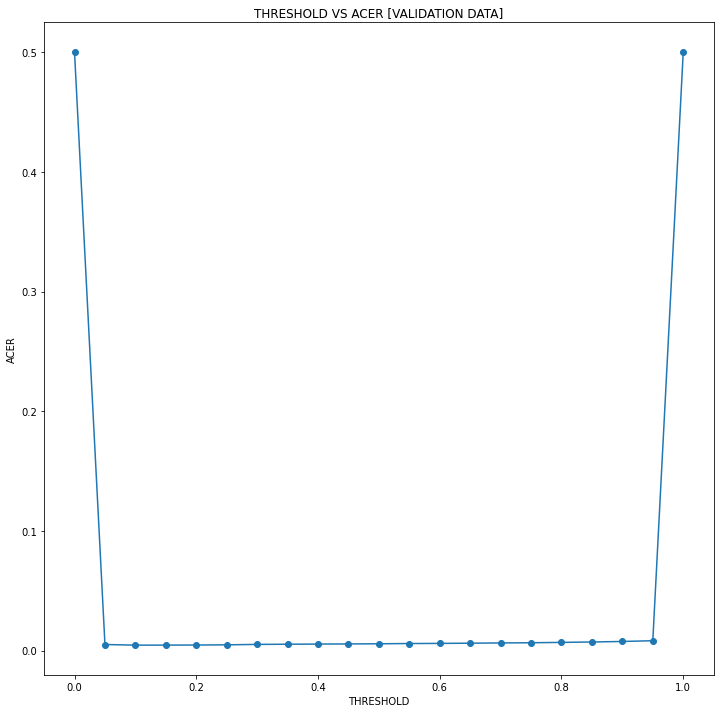

In [ ]:
x_thresh_data = []
y_apcer_data = []
y_bpcer_data = []
y_acer_data = []
for t_l_p in all_thresh_labels_preds_val:
  x_thresh_data.append(t_l_p['thresh'])
  apcer = calculate_apcer(t_l_p['labels'],t_l_p['preds'])
  bpcer = calculate_bpcer(t_l_p['labels'],t_l_p['preds'])
  acer = calculate_acer(apcer,bpcer)
  y_apcer_data.append(apcer)
  y_bpcer_data.append(bpcer)
  y_acer_data.append(acer)

# GRAPH FOR THRESHOLD VS APCER [VALIDATION DATA]
plt.plot(x_thresh_data,y_apcer_data,marker='o')
plt.ylabel('APCER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS APCER [VALIDATION DATA]')
plt.show()

# GRAPH FOR THRESHOLD VS BPCER [VALIDATION DATA]
plt.plot(x_thresh_data,y_bpcer_data,marker='o')
plt.ylabel('BPCER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS BPCER [VALIDATION DATA]')
plt.show()

# GRAPH FOR THRESHOLD VS ACER [VALIDATION DATA]
plt.plot(x_thresh_data,y_acer_data,marker='o')
plt.ylabel('ACER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS ACER [VALIDATION DATA]')
plt.show()


In [ ]:
data = []
for t_l_p in all_thresh_labels_preds_val:
  # print('For threshold -',t_l_p['thresh'],'confusion_matrix is \n')
  # print(t_l_p['labels'])
  # print(tf.math.confusion_matrix(t_l_p['labels'],t_l_p['preds']))
  matrix = tf.math.confusion_matrix(t_l_p['labels'],t_l_p['preds'])
  matrix_str = str(matrix).split('tf.Tensor(')[1].split(',')[0]
  recall = get_recall(matrix)
  recall_str = str(recall).split('tf.Tensor(')[1].split(',')[0] 
  # print('recall - ',recall)
  precision = get_precesion(matrix)
  precision_str = str(precision).split('tf.Tensor(')[1].split(',')[0] 
  # print('precision - ',precision)
  F1_score = get_F1_score(recall,precision)
  F1_score = str(F1_score).split('tf.Tensor(')[1].split(',')[0] 
  # print('F1 score - ',F1_score)
  accuracy = get_acccuracy(matrix, len(t_l_p['labels']))
  accuracy = str(accuracy).split('tf.Tensor(')[1].split(',')[0] 
  # print('accuracy - ',accuracy)
  data.append({ 'matrix': matrix_str, 'thresh': t_l_p['thresh'] , 'recall':recall_str,'precision':precision_str , 'f1_score':F1_score , 'accuracy':accuracy})
  # print('\n')

keys = []
vals = []
for data in data:
    val = []
    for k,v in data.items():
        keys.append(k)
        val.append(v)
    vals.append(val)

pd.DataFrame([v for v in vals], columns=list(dict.fromkeys(keys)))

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(67648, shape=(), dtype=int32)
tf.Tensor(67791, shape=(), dtype=int32)
tf.Tensor(67823, shape=(), dtype=int32)
tf.Tensor(67834, shape=(), dtype=int32)
tf.Tensor(67837, shape=(), dtype=int32)
tf.Tensor(67840, shape=(), dtype=int32)
tf.Tensor(67841, shape=(), dtype=int32)
tf.Tensor(67842, shape=(), dtype=int32)
tf.Tensor(67842, shape=(), dtype=int32)
tf.Tensor(67845, shape=(), dtype=int32)
tf.Tensor(67846, shape=(), dtype=int32)
tf.Tensor(67846, shape=(), dtype=int32)
tf.Tensor(67847, shape=(), dtype=int32)
tf.Tensor(67847, shape=(), dtype=int32)
tf.Tensor(67848, shape=(), dtype=int32)
tf.Tensor(67849, shape=(), dtype=int32)
tf.Tensor(67850, shape=(), dtype=int32)
tf.Tensor(67851, shape=(), dtype=int32)
tf.Tensor(67852, shape=(), dtype=int32)
tf.Tensor(67871, shape=(), dtype=int32)


,matrix,thresh,recall,precision,f1_score,accuracy
0,\n[[ 0 67871]\n [ 0 22305]],0.00,nan,0.0,nan,0.24734962739531582
1,\n[[67648 223]\n [ 154 22151]],0.05,0.9977286805698947,0.9967143551737856,0.997221259941182,0.995819286728176
2,\n[[67791 80]\n [ 177 22128]],0.10,0.9973958333333334,0.9988212933358872,0.9981080543879151,0.9971500177430802
3,\n[[67823 48]\n [ 189 22116]],0.15,0.9972210786331824,0.9992927760015323,0.9982558524613087,0.9973718062455642
4,\n[[67834 37]\n [ 196 22109]],0.20,0.9971189181243569,0.9994548481678478,0.9982855166628649,0.997416163946061
5,\n[[67837 34]\n [ 204 22101]],0.25,0.9970018077335724,0.999499049667752,0.9982488669138855,0.99736071682044
6,\n[[67840 31]\n [ 221 22084]],0.30,0.9967529128281982,0.9995432511676563,0.9981461318894741,0.9972054648687012
7,\n[[67841 30]\n [ 228 22077]],0.35,0.9966504576238816,0.9995579850009577,0.9981021038693543,0.997138928317956
8,\n[[67842 29]\n [ 234 22071]],0.40,0.9965626652564781,0.9995727188342591,0.9980654225543778,0.997083481192335
9,\n[[67842 29]\n [ 239 22066]],0.45,0.9964894757715075,0.9995727188342591,0.9980287160174179,0.997028034066714


In [ ]:
# store all labels and corrosponding predictions only of test set for all different thresholds
# ths = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# all_thresh_labels_preds_test = []
# for t in ths:
#   print('starting calculations for threshold - ',t)
all_labels_test = []
all_predictions_test_raw = []
for step, batch in enumerate(test_loader.dataset):
  pred = revisit_model(batch['image'], batch['label_8'], batch['label_4'], batch['label_2'], batch['label_1'], training=False)
  for i in pred.numpy().reshape(batch['label'].shape[0]):
    all_predictions_test_raw.append(i)
  for i in batch['label'].numpy().reshape(batch['label'].shape[0]):
    label = int(i) 
    all_labels_test.append(label)
  # all_thresh_labels_preds_test.append({ 'thresh': t , 'labels': all_labels_test, 'preds': all_predictions_test })

# save all_thresh_labels_preds_test array into csv file
csv_path_test = "/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/all_labels_preds_test.csv"
a = np.array(all_labels_test)
b = np.array(all_predictions_test_raw)
df = pd.DataFrame({"labels" : a, "preds_raw" : b})
df.to_csv(csv_path_test, index=False)

In [21]:
csv_path_val = "/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50-BiFPN/all_labels_preds_test.csv"
data_from_csv = pd.read_csv(csv_path_val)
# print(data_from_csv['thresh'])
# print(data_from_csv['labels'])
labels = data_from_csv['labels'].tolist()
preds = data_from_csv['preds_raw'].tolist()

thresh = get_thresh_list(0,1.05,0.05)
all_thresh_labels_preds_test = []
for t in thresh:
  preds_ = []
  for p in preds:
    if p > t:
      pred_ = 1
      preds_.append(pred_)
    else:
      pred_ = 0
      preds_.append(pred_)
      
  all_thresh_labels_preds_test.append({ 'thresh': t, 'preds': preds_, 'labels':labels })

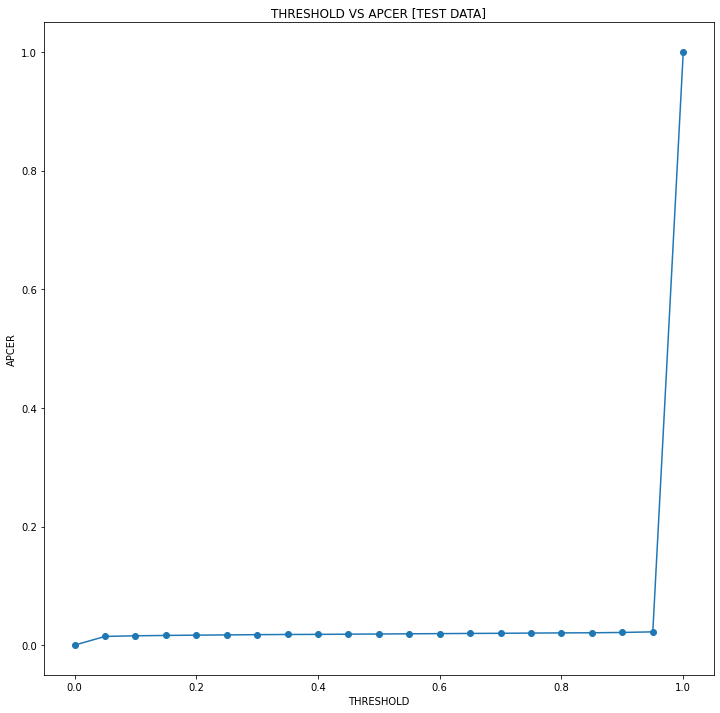

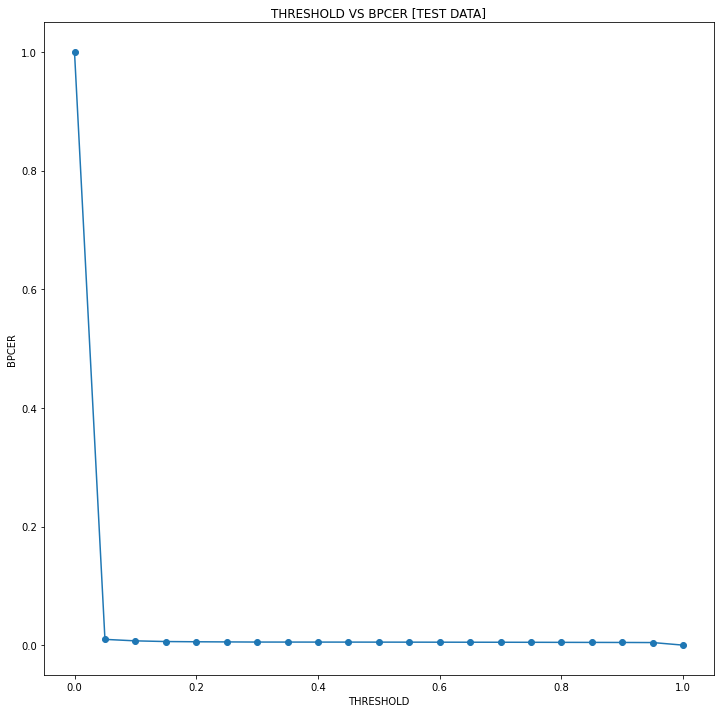

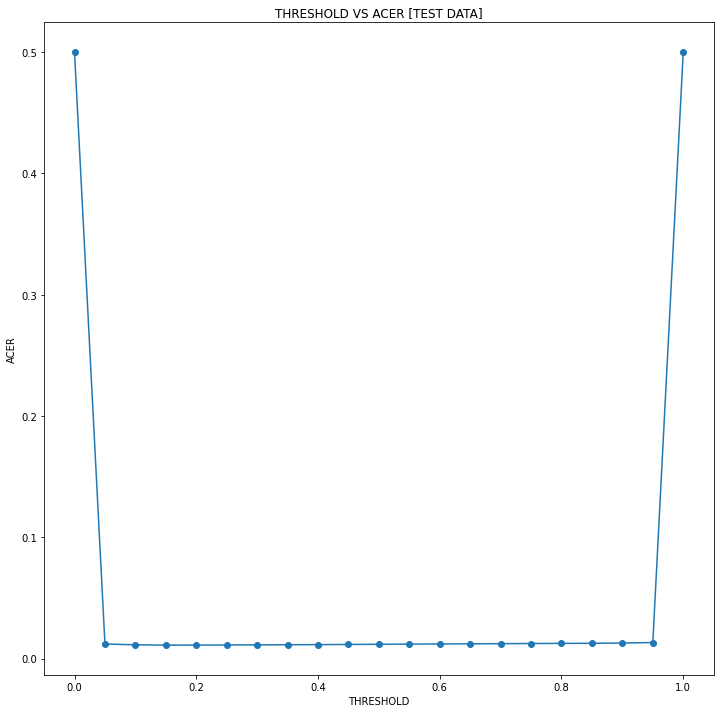

In [22]:
x_thresh_data = []
y_apcer_data = []
y_bpcer_data = []
y_acer_data = []
for t_l_p in all_thresh_labels_preds_test:
  x_thresh_data.append(t_l_p['thresh'])
  apcer = calculate_apcer(t_l_p['labels'],t_l_p['preds'])
  bpcer = calculate_bpcer(t_l_p['labels'],t_l_p['preds'])
  acer = calculate_acer(apcer,bpcer)
  y_apcer_data.append(apcer)
  y_bpcer_data.append(bpcer)
  y_acer_data.append(acer)

# GRAPH FOR THRESHOLD VS APCER [TEST DATA]
plt.plot(x_thresh_data,y_apcer_data,marker='o')
plt.ylabel('APCER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS APCER [TEST DATA]')
plt.show()

# GRAPH FOR THRESHOLD VS BPCER [TEST DATA]
plt.plot(x_thresh_data,y_bpcer_data,marker='o')
plt.ylabel('BPCER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS BPCER [TEST DATA]')
plt.show()

# GRAPH FOR THRESHOLD VS ACER [TEST DATA]
plt.plot(x_thresh_data,y_acer_data,marker='o')
plt.ylabel('ACER')
plt.xlabel('THRESHOLD')
plt.title('THRESHOLD VS ACER [TEST DATA]')
plt.show()


In [ ]:
data = []
for t_l_p in all_thresh_labels_preds_test:
  # print('For threshold -',t_l_p['thresh'],'confusion_matrix is \n')
  # print(t_l_p['labels'])
  # print(tf.math.confusion_matrix(t_l_p['labels'],t_l_p['preds']))
  matrix = tf.math.confusion_matrix(t_l_p['labels'],t_l_p['preds'])
  matrix_str = str(matrix).split('tf.Tensor(')[1].split(',')[0]
  recall = get_recall(matrix)
  recall_str = str(recall).split('tf.Tensor(')[1].split(',')[0] 
  # print('recall - ',recall)
  precision = get_precesion(matrix)
  precision_str = str(precision).split('tf.Tensor(')[1].split(',')[0] 
  # print('precision - ',precision)
  F1_score = get_F1_score(recall,precision)
  F1_score = str(F1_score).split('tf.Tensor(')[1].split(',')[0] 
  # print('F1 score - ',F1_score)
  accuracy = get_acccuracy(matrix, len(t_l_p['labels']))
  accuracy = str(accuracy).split('tf.Tensor(')[1].split(',')[0] 
  # print('accuracy - ',accuracy)
  data.append({ 'matrix': matrix_str, 'thresh': t_l_p['thresh'] , 'recall':recall_str,'precision':precision_str , 'f1_score':F1_score , 'accuracy':accuracy})
  # print('\n')

keys = []
vals = []
for data in data:
    val = []
    for k,v in data.items():
        keys.append(k)
        val.append(v)
    vals.append(val)

pd.DataFrame([v for v in vals], columns=list(dict.fromkeys(keys)))

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(89990, shape=(), dtype=int32)
tf.Tensor(90218, shape=(), dtype=int32)
tf.Tensor(90323, shape=(), dtype=int32)
tf.Tensor(90359, shape=(), dtype=int32)
tf.Tensor(90380, shape=(), dtype=int32)
tf.Tensor(90401, shape=(), dtype=int32)
tf.Tensor(90404, shape=(), dtype=int32)
tf.Tensor(90407, shape=(), dtype=int32)
tf.Tensor(90409, shape=(), dtype=int32)
tf.Tensor(90413, shape=(), dtype=int32)
tf.Tensor(90417, shape=(), dtype=int32)
tf.Tensor(90422, shape=(), dtype=int32)
tf.Tensor(90427, shape=(), dtype=int32)
tf.Tensor(90431, shape=(), dtype=int32)
tf.Tensor(90438, shape=(), dtype=int32)
tf.Tensor(90447, shape=(), dtype=int32)
tf.Tensor(90455, shape=(), dtype=int32)
tf.Tensor(90464, shape=(), dtype=int32)
tf.Tensor(90479, shape=(), dtype=int32)
tf.Tensor(90876, shape=(), dtype=int32)


,matrix,thresh,recall,precision,f1_score,accuracy
0,\n[[ 0 90876]\n [ 0 28932]],0.00,nan,0.0,nan,0.2414863782051282
1,\n[[89990 886]\n [ 425 28507]],0.05,0.9952994525244705,0.9902504511642238,0.9927685323595766,0.9890574919871795
2,\n[[90218 658]\n [ 456 28476]],0.10,0.9949709949930521,0.9927593644086448,0.9938639493252547,0.9907017895299145
3,\n[[90323 553]\n [ 474 28458]],0.15,0.9947795632014274,0.9939147849817334,0.9943469860683756,0.9914279513888888
4,\n[[90359 517]\n [ 488 28444]],0.20,0.9946283311501756,0.9943109291782208,0.9944696048381327,0.9916115785256411
5,\n[[90380 496]\n [ 499 28433]],0.25,0.9945091825394206,0.9945420132928386,0.9945255976451818,0.9916950454059829
6,\n[[90401 475]\n [ 512 28420]],0.30,0.9943682421655868,0.9947730974074563,0.9945706285858881,0.9917618189102564
7,\n[[90404 472]\n [ 520 28412]],0.35,0.9942809379261801,0.9948061094238303,0.9945434543454346,0.9917200854700855
8,\n[[90407 469]\n [ 525 28407]],0.40,0.9942264549333568,0.9948391214402043,0.9945326938308546,0.9917033920940171
9,\n[[90409 467]\n [ 535 28397]],0.45,0.9941172589725545,0.9948611294511203,0.9944890551094488,0.9916366185897436


(64, 256, 256, 3) (64, 256, 256, 3) (64, 1) (64, 8, 8, 1) (64, 4, 4, 1) (64, 2, 2, 1) (64, 1, 1, 1)


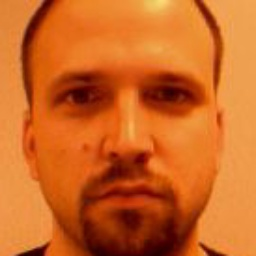

(64, 256, 256, 3) (64, 256, 256, 3) (64, 1) (64, 8, 8, 1) (64, 4, 4, 1) (64, 2, 2, 1) (64, 1, 1, 1)


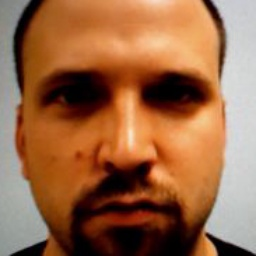

In [ ]:
dataset = val_loader.dataset.take(2)
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['original_image'].shape, a['image'].shape, a['label'].shape, a['label_8'].shape, a['label_4'].shape, a['label_2'].shape, a['label_1'].shape)
  # print(a['image'])
  cv2_imshow(a['original_image'][0])

In [ ]:
ths = 0.76
for step, batch in enumerate(val_loader.dataset):
  pred = revisit_model(batch['image'], batch['label_8'], batch['label_4'], batch['label_2'], batch['label_1'], training=False)
  pred_ = [1 if i>ths else 0 for i in pred.numpy().reshape(batch['label'].shape[0])]
  labels = [int(i) for i in batch['label'].numpy().reshape(batch['label'].shape[0])]
  print(pred.numpy().reshape(batch['label'].shape[0]))
  print(pred_)
  print(labels)
  print(calculate_apcer(labels, pred_))
  print(calculate_bpcer(labels, pred_))
  break

[9.99994159e-01 1.17927685e-03 1.10373694e-04 3.61146173e-04
 9.99994397e-01 2.06404176e-04 1.92608300e-03 1.09330584e-04
 9.99997735e-01 1.24008890e-04 1.99165922e-02 8.83698114e-04
 2.71487021e-04 1.47482532e-03 9.99998808e-01 3.21063184e-04
 1.49443303e-03 2.44511466e-04 1.20925729e-03 4.49222687e-04
 3.81027232e-04 3.41019215e-04 9.99999762e-01 1.00000000e+00
 3.00479966e-04 1.82413100e-03 4.11681045e-04 2.98147410e-04
 1.81788602e-03 9.99994159e-01 2.29046316e-04 1.00000000e+00
 9.99999762e-01 9.99999762e-01 9.99993682e-01 1.67074730e-04
 1.01110218e-02 4.04085877e-04 2.62740359e-04 9.99999881e-01
 1.39953836e-03 3.71853239e-04 1.69368112e-04 1.21535049e-04
 9.99994159e-01 4.94671613e-03 1.92969601e-04 2.32499023e-03
 1.08105433e-03 5.64604474e-04 2.20651564e-04 8.80570896e-03
 4.92195482e-04 9.99996424e-01 4.62633511e-03 3.10042175e-04
 1.59228535e-03 9.65026033e-04 6.42195402e-04 1.45503756e-04
 2.94607511e-04 9.99996543e-01 9.99993205e-01 1.13055226e-03]
[1, 0, 0, 0, 1, 0, 0, 0

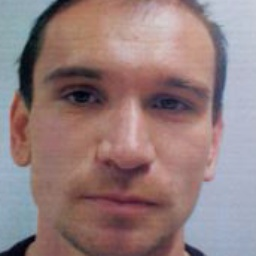

ORIGINAL: ATTACK
0 ~ [0.00152395]
Predicted: ATTACK


In [ ]:
# testing on a single test image
# ATTACK - 0
# REAL - 1
ths = 0.76
idx = 61
dataset = test_loader.dataset.take(1)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
test_img = a[0]['original_image'][idx]
cv2_imshow(test_img)
original_label = a[0]['label'][idx]
if original_label[0] == 0:
  print('ORIGINAL: ATTACK')
else:
  print('ORIGINAL: REAL') 
# for a in list(dataset.as_numpy_iterator()):
#   print(a['original_image'].shape)
#   cv2_imshow(a['original_image'][2])
# revisit_model.predict(a[0]['image'],a[0]['label_8'],a[0]['label_4'],a[0]['label_2'],a[0]['label_1'])
predicted_all = test_model.predict([a[0]['image'],a[0]['label_8'],a[0]['label_4'],a[0]['label_2'],a[0]['label_1']])
predicted = predicted_all[idx]
print(f'{0 if predicted < ths else 1} ~ {predicted}' )
print('Predicted: ATTACK' if predicted < ths else 'Predicted: REAL')
